In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')


In [49]:
import pandas as pd
import seaborn as sns

import numpy as np

from collections import Counter
from sklearn.preprocessing import LabelEncoder

import ipywidgets as widgets

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [50]:
X_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/job_a_thon_2/train_s3TEQDk.csv")
X_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/job_a_thon_2/test_mSzZ8RL.csv")

In [51]:
X_train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [52]:
X_test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [53]:
all_data_na = (X_train.isnull().sum() / len(X_train)) *100
print("Percentage of null values in training set\n",all_data_na)
all_data_na = (X_test.isnull().sum() / len(X_test)) *100
print("Percentage of null values in test set\n",all_data_na)

Percentage of null values in training set
 ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.934073
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64
Percentage of null values in test set
 ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Credit_Product         11.890383
Avg_Account_Balance     0.000000
Is_Active               0.000000
dtype: float64


customer has Credit_product and it can be active or not. And if customer has no Credit_product we can fill no_cp. Therefore we fill Null values with no_cp 

In [54]:

X_train['Credit_Product'] = X_train['Credit_Product'].fillna('no_cp')
X_test['Credit_Product'] = X_test['Credit_Product'].fillna('no_cp')

In [55]:
@widgets.interact(tag=list(X_train.columns))
def display_tag_details(tag='Credit_Product'):
    print(pd.crosstab(index = X_train[tag], columns = X_train['Is_Lead']))

interactive(children=(Dropdown(description='tag', index=7, options=('ID', 'Gender', 'Age', 'Region_Code', 'Occ…

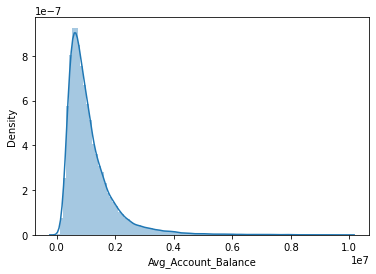

In [56]:
sns.distplot(X_test.Avg_Account_Balance,bins=100)
plt.show()
#the Avg_Account_Balance feature is skewed. We can try transform.

In [ ]:
# X_train['Avg_Account_Balance_tr'] = X_train['Avg_Account_Balance'].apply(lambda x: np.log(1+x))
#tried with log transformation but does not improve result

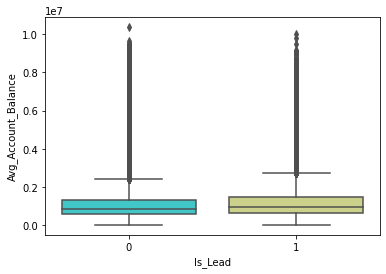

In [57]:
sns.boxplot(x='Is_Lead',y='Avg_Account_Balance',data=X_train,palette='rainbow')
plt.show()
# We can also try removing this feature as it seems like it does not have much affect on Is_Lead feature

In [58]:
X_train = X_train.drop(["ID"],axis=1)
y = X_train["Is_Lead"]
X_train = X_train.drop(["Is_Lead"],axis=1)
X_test = X_test.drop(["ID"],axis=1)


In [59]:
# Gender is removed due to least importance
X_train = X_train.drop(["Avg_Account_Balance","Gender"],axis=1)
X_test = X_test.drop(["Avg_Account_Balance","Gender"],axis=1)

In [60]:
print(X_train.dtypes)

Age                int64
Region_Code       object
Occupation        object
Channel_Code      object
Vintage            int64
Credit_Product    object
Is_Active         object
dtype: object


In [61]:
# Encoding categorical features

cat_columns=[]
for col in X_train.select_dtypes('object').columns:
  print(col)
  cat_columns.append(col)
  le = LabelEncoder()
  X_train[col] = le.fit_transform(X_train[col])
  X_test[col] = le.fit_transform(X_test[col])

Region_Code
Occupation
Channel_Code
Credit_Product
Is_Active


In [ ]:
# Class weights
counts = np.bincount(y)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")
print(counts)
class_weights = list(class_weights.values())
class_weights[1] = class_weights[1]/class_weights[0]
class_weights[0]=1
class_weights
#but this does not seem to have data imbalance problem and
# also tried but does not improve results

In [62]:
# !pip install catboost
from catboost import CatBoostClassifier

#Also tried other algorithms but catboot preformed best

In [63]:
cat_features_index = [i for i,col in enumerate(X_train.columns) if col in cat_columns]
cat_features_index

[1, 2, 3, 5, 6]

In [64]:
from sklearn.model_selection import train_test_split

def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size, stratify=y)
    return X_train, X_val,  y_train, y_val

In [65]:
# Create data splits
X_train_, X_val,  y_train_, y_val = train_val_test_split(
    X=X_train, y=y, train_size=0.8)
print (f"X_train: {X_train_.shape}, y_train: {y_train_.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")

X_train: (196580, 7), y_train: (196580,)
X_val: (49145, 7), y_val: (49145,)


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support

import itertools as it

In [99]:

params = {'iterations': [500,1000] ,
                  'depth': [6], 
                  'learning_rate': [0.1,0.05],  
                  'eval_metric': ['Logloss']}
# Sorting Adict
sorted_params = sorted(params)
# Using product after sorting
param = [dict(zip(sorted_params, prod))
   for prod in it.product(*(params[sorted_params]
      for sorted_params in sorted_params))]
# Printing output
print(param)


[{'depth': 6, 'eval_metric': 'Logloss', 'iterations': 500, 'learning_rate': 0.1}, {'depth': 6, 'eval_metric': 'Logloss', 'iterations': 500, 'learning_rate': 0.05}, {'depth': 6, 'eval_metric': 'Logloss', 'iterations': 1000, 'learning_rate': 0.1}, {'depth': 6, 'eval_metric': 'Logloss', 'iterations': 1000, 'learning_rate': 0.05}]


In [100]:
print(len(param))

4


In [101]:
hp_perf = []

for p in param:
  model = CatBoostClassifier(**p,cat_features = cat_features_index,verbose=False)
  model.fit(X_train_,y_train_)
  ypred_val = model.predict_proba(X_val)
  ypred_train = model.predict_proba(X_train_)

  print("roc_auc: train ",roc_auc_score(y_train_,ypred_train[:,1] ))
  print("roc_auc: test",roc_auc_score(y_val,ypred_val[:,1]))

  ypred_val_class = model.predict(X_val)

  metrics = precision_recall_fscore_support(y_val, ypred_val_class, average="weighted")

  performance = {}
  performance["precision"] = metrics[0]
  performance["recall"] = metrics[1]
  performance["f1"] = metrics[2]
  performance["num_samples"] = np.float64(len(y_val))
  print(performance)
  hp_perf.append(roc_auc_score(y_val,ypred_val[:,1]))


roc_auc: train  0.8775564220170038
roc_auc: test 0.8766846721994864
{'precision': 0.8568016513292164, 'recall': 0.8621629870790518, 'f1': 0.8530575699227788, 'num_samples': 49145.0}
roc_auc: train  0.8762069072706129
roc_auc: test 0.8765737307833136
{'precision': 0.8566498881480409, 'recall': 0.861817071930003, 'f1': 0.8522444142223567, 'num_samples': 49145.0}
roc_auc: train  0.8794176446834769
roc_auc: test 0.8764147107109671
{'precision': 0.8570153140264871, 'recall': 0.8624478583782684, 'f1': 0.8535939443544108, 'num_samples': 49145.0}
roc_auc: train  0.8775786516014309
roc_auc: test 0.876746966340108
{'precision': 0.856597212578908, 'recall': 0.8618984637297792, 'f1': 0.8525824571318951, 'num_samples': 49145.0}


In [102]:
maxpos = hp_perf.index(max(hp_perf))
best_param_setting = param[maxpos]

In [103]:
model = CatBoostClassifier(**best_param_setting,cat_features = cat_features_index)


In [104]:
#train on full training set
model.fit(X_train,y)

0:	learn: 0.6534671	total: 225ms	remaining: 3m 44s
1:	learn: 0.6163271	total: 517ms	remaining: 4m 17s
2:	learn: 0.5833765	total: 785ms	remaining: 4m 20s
3:	learn: 0.5552164	total: 1.02s	remaining: 4m 14s
4:	learn: 0.5303804	total: 1.26s	remaining: 4m 9s
5:	learn: 0.5089704	total: 1.51s	remaining: 4m 9s
6:	learn: 0.4905123	total: 1.77s	remaining: 4m 11s
7:	learn: 0.4749465	total: 2.02s	remaining: 4m 10s
8:	learn: 0.4601329	total: 2.25s	remaining: 4m 7s
9:	learn: 0.4473582	total: 2.48s	remaining: 4m 6s
10:	learn: 0.4358486	total: 2.73s	remaining: 4m 5s
11:	learn: 0.4257330	total: 2.97s	remaining: 4m 4s
12:	learn: 0.4173040	total: 3.2s	remaining: 4m 3s
13:	learn: 0.4096799	total: 3.41s	remaining: 4m
14:	learn: 0.4029340	total: 3.66s	remaining: 4m
15:	learn: 0.3970205	total: 3.9s	remaining: 4m
16:	learn: 0.3922346	total: 4.04s	remaining: 3m 53s
17:	learn: 0.3877227	total: 4.23s	remaining: 3m 51s
18:	learn: 0.3835612	total: 4.45s	remaining: 3m 49s
19:	learn: 0.3799551	total: 4.69s	remaining

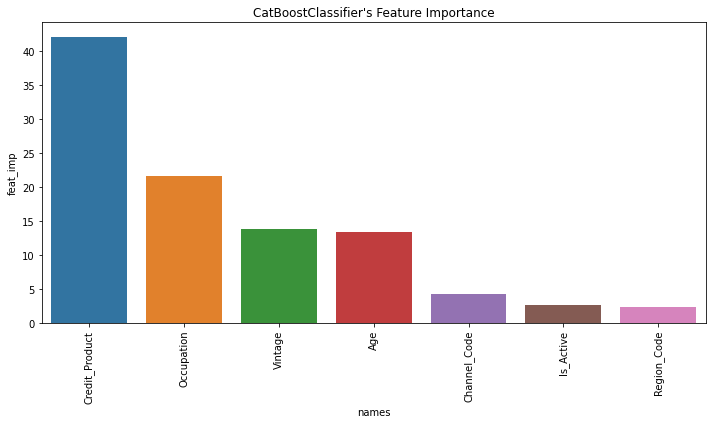

In [105]:
# to see feature importance

names = X_train.columns
df_featimp = pd.DataFrame()
df_featimp['names'] = names
df_featimp['feat_imp'] = model.feature_importances_

plt.figure(figsize=(10, 6)) 
sns.barplot(x="names", y="feat_imp", data=df_featimp.sort_values(by="feat_imp", ascending=False))
plt.title("CatBoostClassifier's Feature Importance")
plt.xticks(rotation='vertical')
plt.tight_layout()

In [106]:
# predict on test set and submit
ypred = model.predict_proba(X_test)

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/job_a_thon_2/sample_submission_eyYijxG.csv",index_col=0)
df['Is_Lead'] = ypred[:,1]

df.to_csv("/content/drive/My Drive/Colab Notebooks/job_a_thon_2/sample_submission_eyYijxG_temp.csv")

In [107]:
best_param_setting


{'depth': 6,
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'learning_rate': 0.05}